In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from datasets import Dataset
import datasets
import torch
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, EvalPrediction

In [ ]:
from pyaspeller import YandexSpeller

speller = YandexSpeller()

In [ ]:
device = 'cpu'
print(device)

cpu


Ниже расположены **вспомогательные функции** для предобработки данных, вычисления метрик и подготовки словарей:

In [ ]:
# Метрики для модели
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Сперва, применяем сигмовидную форму к прогнозам, имеющим вид: (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Затем, используем threshold чтобы превратить их в целочисленные прогнозы
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # Вычисляем метрики
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # Возвращаем в виде dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
# словари для перевода лейблов в числа для модели
labels = [label for label in train.columns if label not in ['Question', 'Category']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

max_length=24

# для трейна
def preprocess_data(examples):
    # берём пакет текстов
    text = examples['Question']
    # кодируем их
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

    # добавляем лейблы
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # создаём массив numpy с shape = (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # Заполняем созданный массив numpy
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

def encoding_dataset(df_train, test_size=0.2):
    # подготовка датасета для модели
    train_df, valid_df = train_test_split(df_train, test_size=test_size, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)
    dataset = datasets.DatasetDict({"train":train_dataset,
                                    "validation":valid_dataset,
                                   })

    encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
    encoded_dataset.set_format("torch")

    return encoded_dataset

In [ ]:
# для теста и отложенного датасета
def preprocess_test(examples):
    # берём пакет текстов
    text = examples['Question']
    # кодируем их
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

    return encoding

def encoding_test(df_test):
    # подготовка датасета для модели
    test_dataset = Dataset.from_pandas(df_test)
    dataset = datasets.DatasetDict({"test":test_dataset})

    encoded_dataset = dataset.map(preprocess_test, batched=True, remove_columns=dataset['test'].column_names)
    encoded_dataset.set_format("torch")

    return encoded_dataset

Подготовка *тренировочного датафрейма* (удаление дубликатов, пропущенных значений и т.д.):

In [ ]:
# дополнительные аугументации в разных файлых
frame_list = ['data/train_data_new0.csv', 'data/train_data_new1-.csv', 'data/train_data_spell.csv',
              'data/call_operator.csv', 'data/19_osn.csv', "data/train_ayg.csv", "data/train_data_new_new.csv"]
train = pd.concat(map(pd.read_csv, frame_list), ignore_index=True)
train.drop_duplicates(subset=['Question'], inplace=True, ignore_index=True)
train = train[['Question', 'Category', 'answer_class']]
train.dropna(how='any', axis=0, ignore_index=True, inplace=True)
train = train[train.answer_class!=30]  # уберем вызов оператора
train['answer_class'] = train['answer_class'].astype(int)
train.head()

,Question,Category,answer_class
0,Где можно узнать о документах или сертификатах...,Документы,0
1,Какой документ я получу после обучения?,Документы,0
2,Какие аккредитации или удостоверения я могу ож...,Документы,0
3,Как происходит выдача дипломов студентам?,Документы,0
4,"Где можно узнать о том, как получить документы...",Документы,0


In [ ]:
train.shape

(1364, 3)

In [ ]:
# отложенный датасет для проверки - размеченный вручную
hold = pd.read_csv('data/hold_data.csv', sep=',', index_col=None)
test_labels = hold['answer_class'].tolist()
hold.head()

,Question,Category,answer_class
0,Получу ли я диплом государственного образца по...,Документы,0
1,Что я получу если сдам все экзамены?,Документы,0
2,"Если я не сдам один экзамен, могу ли я получит...",Документы,1
3,Как оцениваются компетенции?,Документы,1
4,"Если я еще учусь в университете, могу я получи...",Документы,2


In [ ]:
# максимальная длина документа
seq_len_train = [len(str(i).split()) for i in train['Question']]
max_seq_len = max(seq_len_train)
# если меньше 512 tokenizer(max_length) уменьшить,чтобы не было пустоты
max_seq_len

20

<Axes: >

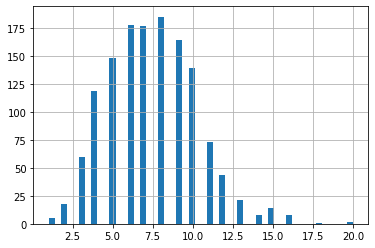

In [ ]:
seq_len = [len(str(i).split()) for i in train['Question']]
pd.Series(seq_len).hist(bins = 50)

In [ ]:
train = pd.get_dummies(train, columns=['answer_class'], prefix='', prefix_sep='', dtype=bool, drop_first= False)
train.head()

,Question,Category,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,Где можно узнать о документах или сертификатах...,Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Какой документ я получу после обучения?,Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Какие аккредитации или удостоверения я могу ож...,Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Как происходит выдача дипломов студентам?,Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"Где можно узнать о том, как получить документы...",Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
hold = pd.get_dummies(hold, columns=['answer_class'], prefix='', prefix_sep='', dtype=bool, drop_first= False)
hold.head()

,Question,Category,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,Получу ли я диплом государственного образца по...,Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Что я получу если сдам все экзамены?,Документы,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"Если я не сдам один экзамен, могу ли я получит...",Документы,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Как оцениваются компетенции?,Документы,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"Если я еще учусь в университете, могу я получи...",Документы,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_answer_class = pd.read_csv('train_SecondPilot/answer_class.csv', sep=',', index_col=None)

In [ ]:
model_name = 'bert-base-multilingual-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
encoded_dataset = encoding_dataset(train, test_size=0.2)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# пример для проверки
i=0
example = encoded_dataset['train'][i]
print(example.keys())
print(example['labels'])
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])
print(tokenizer.decode(example['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
['15']
[CLS] какие ресурсы доступны в основном обучении через личныи кабинет? [SEP] [PAD] [PAD]


Ниже выполняется **тренировка модели**:

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      problem_type="multi_label_classification",
                                                      num_labels=len(labels),
                                                      id2label=id2label,
                                                      label2id=label2id).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 1  # меньшие - ухудшают результат до случайного
metric_name = "f1"

args = TrainingArguments(
    output_dir = "training/results",        # Выходной каталог
    evaluation_strategy = "epoch",          # Валидация после каждой эпохи (можно после конкретного кол-ва шагов)
    save_strategy = "epoch",                # Сохранение после каждой эпохи
    learning_rate=1e-5,                     # Скорость обучения 1e-5 = 0,00001
    per_device_train_batch_size=batch_size, # Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size=batch_size,  # Размер пакета для каждого устройства во время валидации
    num_train_epochs=20,                    # Кол-во эпох для обучения
    weight_decay=0.01,                      # Понижение весов
    load_best_model_at_end=True,            # Загружать ли лучшую модель после обучения
    metric_for_best_model=metric_name,
    save_total_limit = 1,
    seed=42,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.138700,0.128469,0.000000,0.500000,0.000000
2,0.111300,0.097781,0.411429,0.631552,0.263736
3,0.081800,0.073060,0.564767,0.699381,0.399267
4,0.059500,0.056977,0.683962,0.765189,0.531136
5,0.043000,0.044352,0.809224,0.852785,0.706960
6,0.028600,0.040179,0.851485,0.892699,0.787546
7,0.022900,0.032140,0.885880,0.918467,0.838828
8,0.017700,0.029485,0.889734,0.927371,0.857143
9,0.013700,0.040343,0.845865,0.909941,0.824176
10,0.011900,0.025763,0.903592,0.936655,0.875458


TrainOutput(global_step=21820, training_loss=0.03140109504012205, metrics={'train_runtime': 1791.4378, 'train_samples_per_second': 12.18, 'train_steps_per_second': 12.18, 'total_flos': 269180931576960.0, 'train_loss': 0.03140109504012205, 'epoch': 20.0})

**Валидация**:

In [ ]:
# встроенная валидация
trainer.evaluate()

{'eval_loss': 0.022703271359205246,
 'eval_f1': 0.9158878504672897,
 'eval_roc_auc': 0.9476443097132752,
 'eval_accuracy': 0.8974358974358975,
 'eval_runtime': 2.4575,
 'eval_samples_per_second': 111.086,
 'eval_steps_per_second': 111.086,
 'epoch': 20.0}

**Отложенный датасет**:

In [ ]:
def get_prediction_(dataset):
    # предсказание для теста
    pred = trainer.predict(dataset)
    labels = np.argmax(pred.predictions, axis = -1)
    labels = [id2label[idx] for idx in list(labels)]
    return labels

def get_prediction(dataset):
    # предсказание для датасета
    pred = trainer.predict(dataset)
    predict = pred.predictions
    labels = np.argmax(predict, axis = -1)
    score = np.max(predict, axis = -1)
    return labels, score

In [ ]:
test_dataset = encoding_datatest(hold[['Question']])

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
pred, score = get_prediction(test_dataset['test'])

In [ ]:
# валидация sklearn
print(classification_report(test_labels, pred))
print(f1_score(test_labels, pred, average='micro'))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.50      1.00      0.67         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         2
           9       0.67      1.00      0.80         2
          10       0.50      0.50      0.50         2
          11       1.00      1.00      1.00         2
          12       0.50      1.00      0.67         2
          13       0.50      0.50      0.50         2
          14       1.00      0.50      0.67         2
          15       0.20      0.50      0.29         2
          16       0.50      1.00      0.67         2
          17       1.00    

/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0.98, 'Plot of confusion matrix')

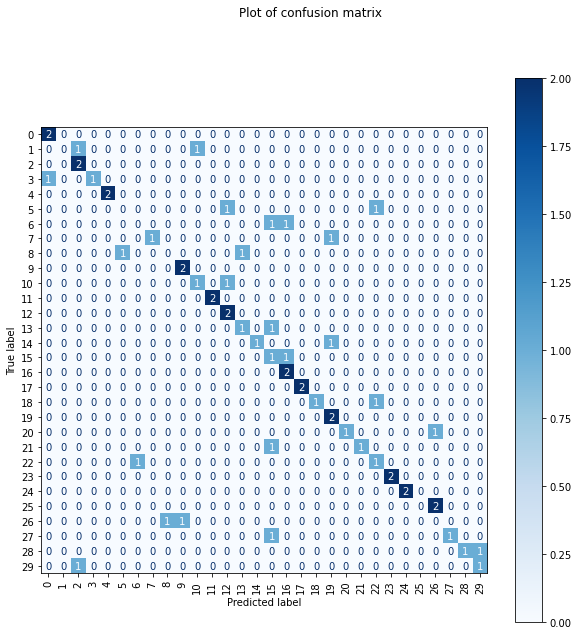

In [ ]:
cmp = ConfusionMatrixDisplay.from_predictions(test_labels, pred, xticks_rotation = 'vertical', cmap=plt.cm.Blues)
fig = cmp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('Plot of confusion matrix')

**Словарь класс/группа**:

In [ ]:
# словарь перевода классов в группы
label_dist = {0: 'Документы',
             1: 'Документы',
             2: 'Документы',
             3: 'Документы',
             4: 'Документы',
             5: 'Организация уроков',
             6: 'Организация уроков',
             7: 'Организация уроков',
             8: 'Организация уроков',
             9: 'Организация уроков',
             10: 'Оценки',
             11: 'Перевод/ запись в группу',
             12: 'Практические работы',
             13: 'Программа обучения',
             14: 'Портал',
             15: 'Портал',
             16: 'Портал',
             17: 'Портал',
             18: 'Портал',
             19: 'Программа обучения',
             20: 'Программа обучения',
             21: 'Расписание',
             22: 'Расписание',
             23: 'Требования ПО',
             24: 'Требования ПО',
             25: 'Трудоустройство',
             26: 'Трудоустройство',
             27: 'Трудоустройство',
             28: 'Документы',
             29: 'Документы',
             30: 'Переключить на оператора',
             }

**Тестовое предсказание для одного текста**:

In [ ]:
def predict_text(text):
    # предсказание для одного текста
    text = speller.spelled(text)

    encoding = tokenizer(text, return_tensors="pt", max_length=12)
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = trainer.model(**encoding)
    logits = outputs.logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().to("cpu"))
    predictions = np.zeros(probs.shape)
    scores = max(probs).item()
    predictions[np.where(probs == max(probs))] = 1  # один лейбл
    predicted_labels = [idx for idx, label in enumerate(predictions) if label == 1.0]
    answer = train_answer_class[train_answer_class.answer_class==predicted_labels[0]]['Answer'].values[0]

    return predicted_labels[0], label_dist[predicted_labels[0]], answer, round(scores, 2)

In [ ]:
texts = "Когда отдыхаем?"
predict_text(texts)

(21,
 0.95,
 'Расписание',
 'Расписание каникул на 2024:\n\n26 декабря 2023 — 8 января 2024\n29 апреля — 14 мая\n7 августа — 20 августа\n30 октября — 12 ноября')